In [1]:
import matplotlib.pyplot as plt, pandas as pd, transforms as T
import argparse, os, csv, torch, json
import numpy as np, random, torch.nn as nn
import torch.nn.functional as F
from constants import *
from torchvision import transforms
from dataset import FewShotDataset
from torch.utils.data import Subset
from model import distance, model_registry
from dataset import transforms_registry
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ImportError: cannot import name 'FewShotDataset' from 'dataset' (/mnt/d/DATN/CatRecognition2/dataset.py)

In [2]:
INPUT_SIZE = 84
N_WAY = 5
N_SHOT = 5
N_QUERY = 5

transforms = transforms_registry["test"](INPUT_SIZE)

selected_folders_df = pd.read_csv(SELECTED_FOLDERS_FOR_MODEL)
selected_folders = selected_folders_df[selected_folders_df["type"] == "test"]["folder"].astype(str).tolist()


dataset = FewShotDataset(FORMATTED_PHOTO_FOLDER, selected_folders, transform=transforms,
                            n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY,
                            n_episodes=1)

In [3]:
HIDDEN_DIM = 64
OUTPUT_DIM = 64

log_folder = input("Log folder: ")

args = argparse.Namespace()
args_file = os.path.join(log_folder, LOGS_ARGS_FILE_NAME)
with open(args_file, "r") as f:
    args.__dict__ = json.load(f)

model = model_registry[args.model]().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.load_state_dict(torch.load(os.path.join(log_folder, LOGS_MODEL_FILE_NAME)))
optimizer.load_state_dict(torch.load(os.path.join(log_folder, LOGS_OPTIMIZER_FILE_NAME)))

model.eval()


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13604\2732990516.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(log_folder, L

ModelD(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3

In [4]:
# print number of parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}, Trainable parameters: {trainable_params}")

Total parameters: 3913728, Trainable parameters: 3913728


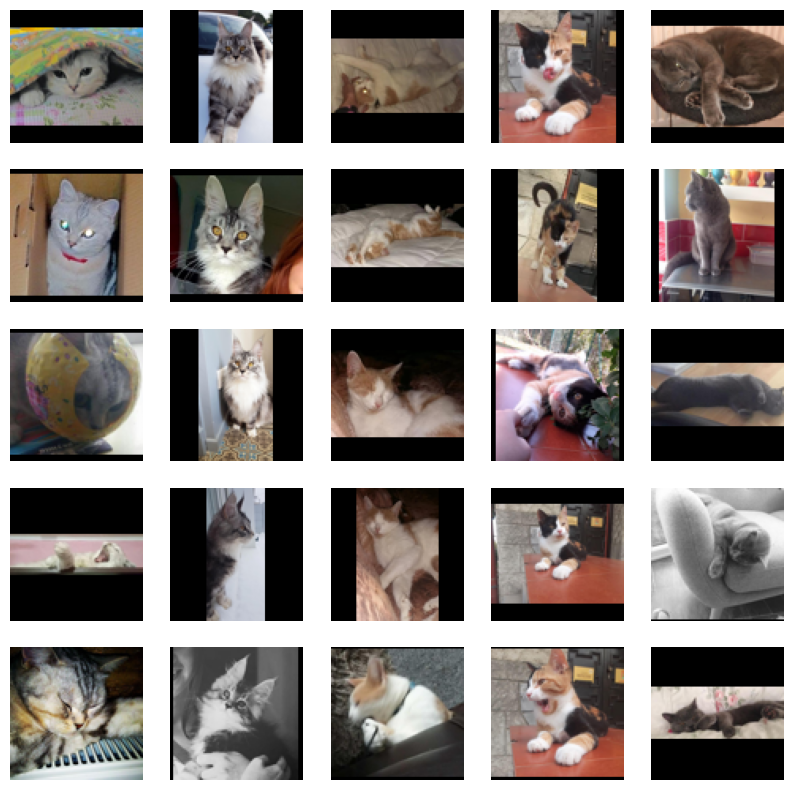

colums: 5, rows: 5


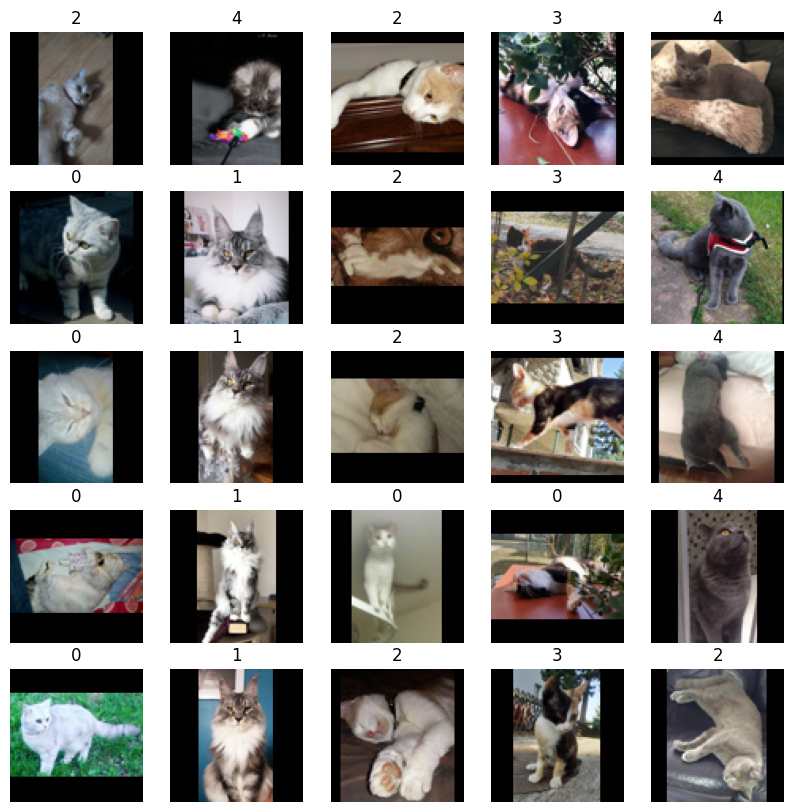

In [6]:
for support_set, query_set in Subset(dataset, range(1)):
    support_set = support_set.squeeze(0).to(device)
    query_set = query_set.squeeze(0).to(device)
    
    n_class = support_set.size(0)
    n_support = support_set.size(1)
    n_query = query_set.size(1)
    
    input = torch.cat([support_set.view(n_class * n_support, *support_set.size()[2:]), 
                    query_set.view(n_class * n_query, *query_set.size()[2:])], dim=0)
    
    output = model(input)
    
    out_support = output[:n_class * n_support]
    out_query = output[n_class * n_support:]
    
    prototypes = out_support.view(n_class, n_support, -1).mean(dim=1) # Shape: [n_class, feature_dim]
    
    dists = distance(prototypes, out_query)
    
    log_p_y = F.log_softmax(-dists, dim=1).view(n_class, n_query, -1)

    _, y_hat = log_p_y.max(2)

    support_set = support_set.cpu()
    query_set = query_set.cpu()
    cols = n_class 
    rows = n_support 
    fig = plt.figure(figsize=(cols * 2, rows * 2))
    for i in range(cols):
        for j in range(rows):
            ax = fig.add_subplot(rows, cols, i + j * cols + 1)
            ax.imshow(support_set[i, j].permute(1, 2, 0))
            ax.axis("off")
    plt.show()
    
    print(f"colums: {cols}, rows: {rows}")
    fig = plt.figure(figsize=(cols * 2, rows * 2))
    for i in range(cols):
        for j in range(rows):
            ax = fig.add_subplot(rows, cols, i + j * cols + 1)
            ax.imshow(query_set[i, j].permute(1, 2, 0))
            ax.axis("off")
            ax.set_title(f"{y_hat[i, j].item()}")
            
    plt.show()

    
    
    